# Visualizaing Molecules with Pyvista

In [1]:
import molli as ml
import pyvista as pv
from PIL import ImageColor
from matplotlib.colors import ListedColormap
import numpy as np


In [2]:

with open(ml.files.dendrobine_mol2) as f:
    _mol = ml.chem.Molecule.load_mol2(f)

mol = _mol.heavy
# mol = _mol

mol.translate(-1 * mol.centroid())
a_sizes = [a.cov_radius_1 for a in mol.atoms]


In [3]:

# print(pv.Report())
pv.set_plot_theme("dark")  # "document" for light settings!
# pv.set_jupyter_backend("static")
plotter = pv.Plotter(notebook=True)


/home/blakeo2/miniconda3/envs/b_dev3/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


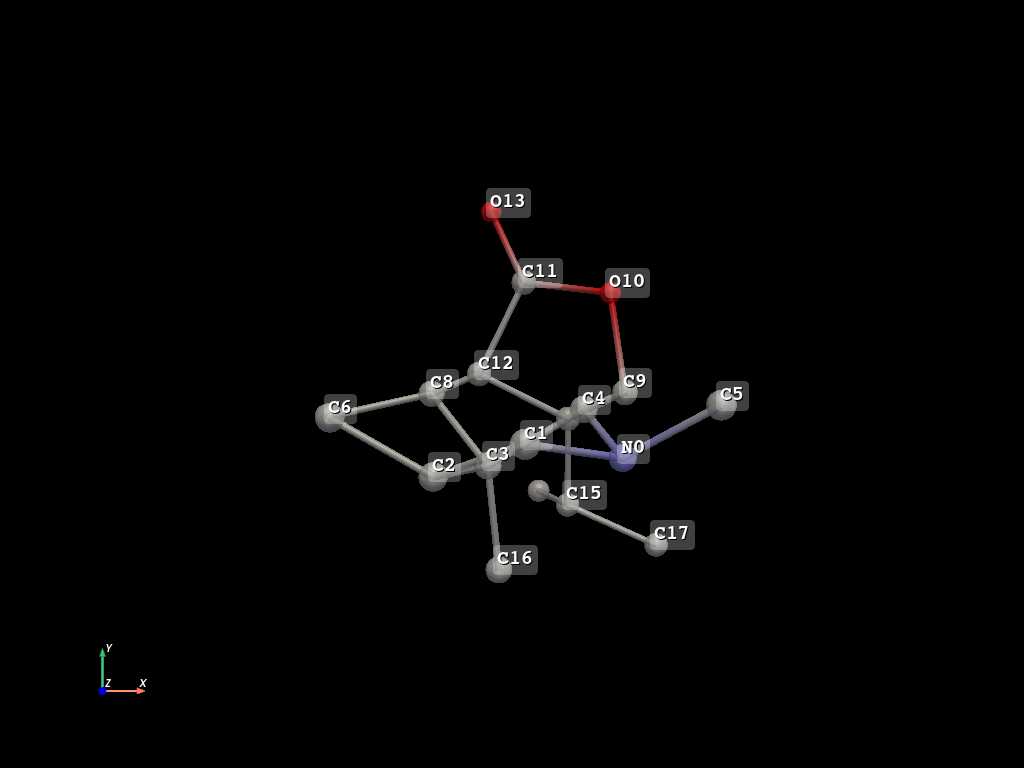

In [4]:

sph = pv.Sphere(theta_resolution=32, phi_resolution=32)

b_lines = []
for b in mol.bonds:
    i1, i2 = map(mol.get_atom_index, (b.a1, b.a2))
    b_lines.append((2, i1, i2))

points = pv.PolyData(mol.coords, lines=b_lines, n_lines=mol.n_bonds)
points.point_data["element"] = [a.Z for a in mol.atoms]
points["radius"] = a_sizes


val = np.linspace(-1, 118, 120)
colors = np.zeros((120, 4))
for i, elt in enumerate(ml.chem.Element):
    clr = elt.color_cpk or "#000000"
    r, g, b = ImageColor.getrgb(clr)
    colors[val > (elt.z - 0.5)] = [r / 255, g / 255, b / 255, 1]

cmap_cpk = pv.LookupTable(
    ListedColormap(colors), n_values=120, scalar_range=(-1, 118)
)

spherez = points.glyph(
    geom=sph,
    orient=False,
    scale="radius",
    factor=0.5,
    # progress_bar=True,
)

tubez = points.tube(
    radius=0.05,
    # progress_bar=True,
    n_sides=24,
    capping=False,
)


plotter.add_mesh(
    spherez,
    color="white",
    smooth_shading=True,
    scalars="element",
    show_scalar_bar=False,
    diffuse=0.7,
    ambient=0.1,
    specular=0.2,
    specular_power=5,
    cmap=cmap_cpk,
    culling=True,
)

plotter.add_mesh(
    tubez,
    color="white",
    smooth_shading=True,
    scalars="element",
    show_scalar_bar=False,
    diffuse=0.7,
    ambient=0.1,
    specular=0.2,
    specular_power=5,
    interpolate_before_map=False,
    cmap=cmap_cpk,
    culling=True,
)

heavy = pv.PolyData(mol.heavy.coords)
heavy["labels"] = [
    f"{a.element.symbol}{i}" for i, a in enumerate(mol.heavy.atoms)
]

plotter.add_point_labels(
    heavy,
    "labels",
    font_size=20,
    shadow=True,
    shape_color="white",
    shape_opacity=0.25,
    show_points=False,
    always_visible=True,
    margin=5,
    font_family="courier",
)

plotter.enable_anti_aliasing(aa_type="msaa", multi_samples=4)
plotter.view_xy()
plotter.add_axes()
# plotter.enable_stereo_render()

plotter.show()